In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from langdetect import detect
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

In [102]:
#Leer el archivo parquet que sale del preprocess.py
path = '/export/usuarios_ml4ds/lbartolome/NextProcurement/data/processed_10_abr/trf_lote_es.parquet'
df_preprocesado = pd.read_parquet(path)

In [103]:
def det(x: str) -> str:
    try:
        lang = detect(x)
        print(lang)
    except:
        lang = 'Other'
    return lang

In [104]:
print(df_preprocesado.columns)

Index(['id_tm', 'raw_text', 'lemmas'], dtype='object')


# Cargando modelo tópicos

In [105]:
# Cargar descripciones de tópicos, es la salida del modelo LDA
#tpc_descriptions_path = "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/Mallet_5_topics/model_data/TMmodel/tpc_descriptions.txt"
#tpc_descriptions = pd.read_csv(tpc_descriptions_path, header=None, names=['description'])

# Cargar etiquetas de tópicos
#tpc_labels_path = "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/Mallet_5_topics/model_data/TMmodel/tpc_labels.txt"
#tpc_labels = pd.read_csv(tpc_labels_path, header=None, names=['label'])

# Cargar embeddings de tópicos, ahora mismo no son necesarias
#tpc_embeddings_path = "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/Mallet_5_topics/model_data/TMmodel/tpc_embeddings.npy"
#tpc_embeddings = np.load(tpc_embeddings_path, allow_pickle=True)

In [106]:
#tpc_descriptions

In [107]:
#tpc_embeddings.shape

# Cargando el corpus

In [108]:
# Cargar el corpus
#corpus_path = "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/Mallet_5_topics/train_data/corpus.txt"
#corpus_df = pd.read_csv(corpus_path, header=None, names=['description'], index_col=False)

In [109]:
#corpus_df

In [110]:
def quitar_prefijo(texto):
    
    patron = r'^\d+\t\d+\t'
    texto_modificado = re.sub(patron, '', texto)
    
    return texto_modificado

In [111]:
#corpus_df['description'] = corpus_df['description'].apply(quitar_prefijo)

In [112]:
#pd.set_option('max_colwidth', None)

In [113]:
#corpus_df

In [114]:
'''
def generar_dataframe_desde_txt(vocab_path):
    # Inicializar listas para almacenar los componentes separados
    palabras = []
    freqs = []

    # Abrir el archivo para lectura
    with open(vocab_path, 'r', encoding='utf-8') as archivo:
        # Iterar sobre cada línea del archivo
        for linea in archivo:
            # Dividir la línea por el tabulador
            partes = linea.strip().split('\t')
            # Asegurar que la línea tiene exactamente dos partes
            if len(partes) == 2:
                palabra, freq = partes
                palabras.append(palabra)
                freqs.append(int(freq)) 

    # Crear un df con las listas de palabras y frecuencias
    df = pd.DataFrame({
        'palabra': palabras,
        'freq': freqs
    })

    return df
'''

"\ndef generar_dataframe_desde_txt(vocab_path):\n    # Inicializar listas para almacenar los componentes separados\n    palabras = []\n    freqs = []\n\n    # Abrir el archivo para lectura\n    with open(vocab_path, 'r', encoding='utf-8') as archivo:\n        # Iterar sobre cada línea del archivo\n        for linea in archivo:\n            # Dividir la línea por el tabulador\n            partes = linea.strip().split('\t')\n            # Asegurar que la línea tiene exactamente dos partes\n            if len(partes) == 2:\n                palabra, freq = partes\n                palabras.append(palabra)\n                freqs.append(int(freq)) \n\n    # Crear un df con las listas de palabras y frecuencias\n    df = pd.DataFrame({\n        'palabra': palabras,\n        'freq': freqs\n    })\n\n    return df\n"

In [115]:
#vocab_path = "/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/sample_data/models/Mallet/Mallet_5_topics/model_data/vocab_freq.txt"
#df = generar_dataframe_desde_txt(vocab_path)
#df_ordenado = df.sort_values(by='freq', ascending=False).reset_index(drop=True)

In [116]:
#vocab = pd.read_csv(vocab_path, header=None,index_col=False)

In [117]:
#df_ordenado.to_csv('palabras_con_freq.csv',index = False)

# Sacando stopwords TF-IDF

In [10]:
#Leer el archivo parquet que sale del preprocess.py
path = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/sample_data/all_processed/trf_lote_es_sin_duplicados.parquet'
df_preprocesado = pd.read_parquet(path)

In [11]:
df_preprocesado

,identifier,id_tm,raw_text,lemmas
0,contratosMenoresPerfilesContratantes_2018.zip/...,0,Reforma de elementos de ventilación exterior d...,reforma elemento ventilación exterior aire_aco...
1,contratosMenoresPerfilesContratantes_2018.zip/...,1,Servicios de calibrado y certificado de dos de...,calibrado certificado detector portátil gas tr...
2,contratosMenoresPerfilesContratantes_2018.zip/...,3,Redacción EPIA - Legalización antena emisora d...,epia legalización antena emisora_radio narcea
3,contratosMenoresPerfilesContratantes_2018.zip/...,4,Obras de reparación del Centro de Información ...,centro información naturaleza rellano
4,contratosMenoresPerfilesContratantes_2018.zip/...,5,Diversos materiales para el acondicionamiento ...,rotonda arriat decoracion jardinera maceta via...
...,...,...,...,...
2637229,PlataformasAgregadasSinMenores_202401.zip/Plat...,3110253,Servicios para el desarrollo y gestión del pro...,euskara merkataritzara pueblo
2637230,PlataformasAgregadasSinMenores_202401.zip/Plat...,3110254,Suministro y montaje de VALORIZA: Separación y...,montaje valoriza separación reciclado residuo ...
2637232,PlataformasAgregadasSinMenores_202401.zip/Plat...,3110256,concesion de servicios de peluquerías en 10 cp...,concesion cpas dependiente dt
2637235,PlataformasAgregadasSinMenores_202401.zip/Plat...,3110259,"Investigación, validación, verificación y gest...",validación verificación documental proyecto pacto


In [12]:
def get_filtered_words(text, threshold):
    # Inicializar el vectorizador TF-IDF sin un vocabulario específico
    vectorizer = TfidfVectorizer()    
    # Ajustar el vectorizador al texto para calcular valores IDF
    vectorizer.fit(text)
    # Obtener los nombres de las características (palabras) y sus valores IDF
    feature_names = vectorizer.get_feature_names_out()
    idf_values = vectorizer.idf_

    # Filtrar palabras de baja importancia: comunes en el corpus (IDF menor o igual al umbral)
    low_importance_words = [word for word, idf in zip(feature_names, idf_values) if idf < threshold]
    # Filtrar palabras de alta importancia: raras en el corpus (IDF mayor al umbral)
    high_importance_words = [word for word, idf in zip(feature_names, idf_values) if idf >= threshold]

    # Contar el número de palabras en cada subconjunto
    num_low_importance_words = len(low_importance_words)
    num_high_importance_words = len(high_importance_words)

    # Imprimir resultados
    print(f"Palabras comunes en el corpus (total: {num_low_importance_words}):\n", low_importance_words)
    print(f"Palabras raras en el corpus (total: {num_high_importance_words}):\n", high_importance_words)

    # Retornar los subconjuntos de palabras y sus conteos
    return low_importance_words, high_importance_words, num_low_importance_words, num_high_importance_words, feature_names

In [13]:
#Sirve para analizar el idf de las palabras
def get_idf_values(text):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(text)
    feature_names = vectorizer.get_feature_names_out()
    idf_values = vectorizer.idf_
    return feature_names, idf_values

#Sirve para sacar que palabras son las más repetidas
def get_tf_values(text):
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(text)
    total_word_counts = word_counts.sum(axis=0)
    # Obtener los nombres de las palabras
    feature_names = vectorizer.get_feature_names_out()
    
    # Convertir las frecuencias de término a un array de numpy
    tf_values = total_word_counts.A1
 
    # Ordenar las palabras por frecuencia de término
    sorted_tf_indices = np.argsort(tf_values)[::-1]
    sorted_words = feature_names[sorted_tf_indices]
    sorted_tf_values = tf_values[sorted_tf_indices]
    
    # Crear listas de las palabras y sus frecuencias ordenadas
    sorted_word_frequency = [(word, freq) for word, freq in zip(sorted_words, sorted_tf_values)]
    
    # Retornar la lista de palabras y frecuencias ordenadas
    return sorted_word_frequency

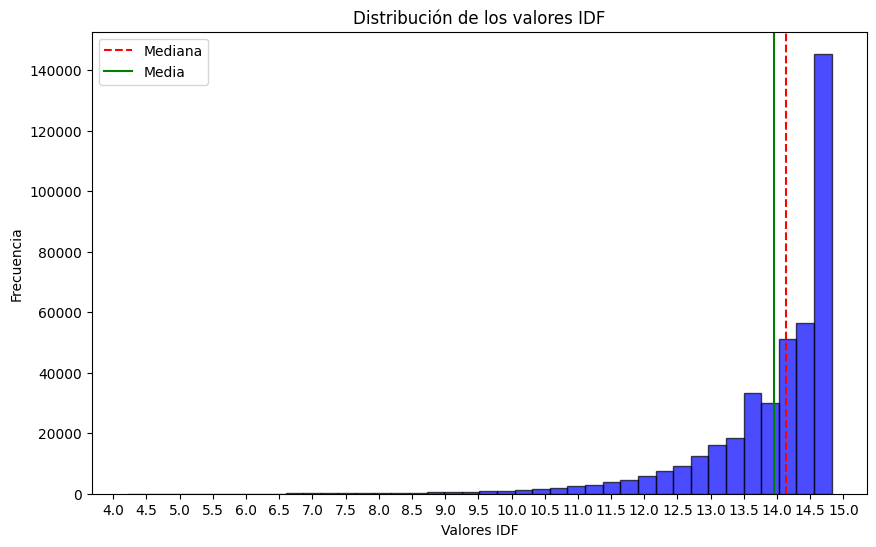

In [14]:
#Graficando los valores de idf para escoger el threshold
text = df_preprocesado['lemmas']
feature_names, idf_values = get_idf_values(text)

# Distribución de los valores IDF
plt.figure(figsize=(10, 6))
plt.hist(idf_values, bins=40, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribución de los valores IDF')
plt.xlabel('Valores IDF')
plt.ylabel('Frecuencia')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))  
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  
plt.axvline(x=np.median(idf_values), color='red', linestyle='--', label='Mediana')
plt.axvline(x=np.mean(idf_values), color='green', linestyle='-', label='Media')
plt.legend()
plt.show()

In [15]:
sorted_word_frequency = get_tf_values(text)
for word, freq in sorted_word_frequency[:100]:  
    print(f"{word}: {freq}")

servicio: 83822
ayuntamiento: 47875
centro: 45769
actuación: 43469
actividad: 41856
nº: 31722
sustitución: 29288
municipio: 28234
municipal: 27084
renovación: 25934
unidad: 25923
adecuación: 24954
acceso: 24734
deportivo: 24592
soporte: 23311
construcción: 23179
prestación: 21680
reforma: 21472
equipamiento: 20162
diseño: 20058
ciudad: 19553
planta: 19235
plaza: 18793
sala: 18441
espacio: 17847
cultural: 17644
evento: 17552
apoyo: 17406
comunicación: 17234
laboratorio: 17185
integral: 17077
proyecto: 17048
salud: 17020
provincia: 16960
objeto: 16789
infantil: 16566
montaje: 16042
ampliación: 15746
dependencia: 15614
mobiliario: 15518
fiesta: 15461
digital: 15358
conservación: 15269
celebración: 15175
rehabilitación: 15117
camino: 15077
vigilancia: 14787
grupo: 14563
producción: 14500
plataforma: 14117
ceip: 14071
octubre: 14062
reposición: 14024
mes: 13963
puerta: 13875
fase: 13770
servicios: 13732
sede: 13687
provincial: 13668
mayo: 13483
diputación_provincial: 13480
teatro: 13466
dic

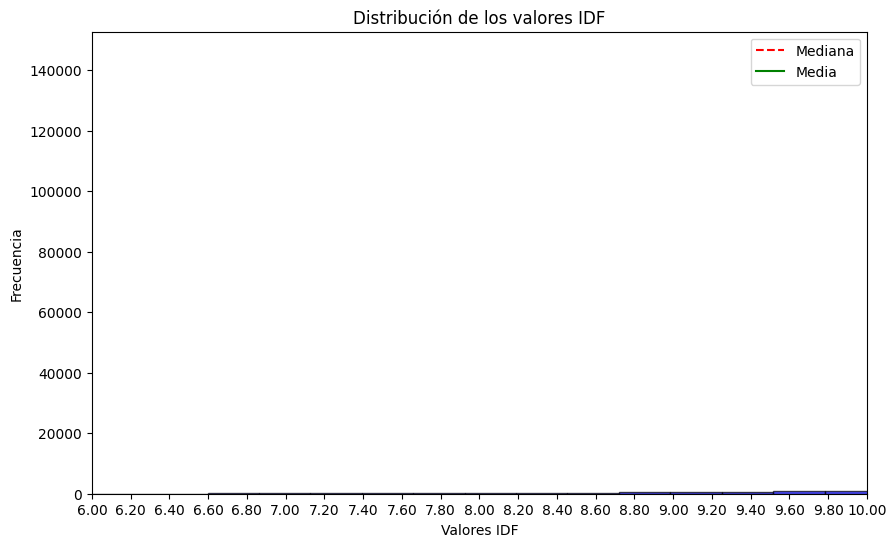

In [17]:
# Distribución de los valores IDF
plt.figure(figsize=(10, 6))
plt.hist(idf_values, bins=40, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribución de los valores IDF')
plt.xlabel('Valores IDF')
plt.ylabel('Frecuencia')

# Ajustar las marcas y el formato del eje X para el zoom
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # intervalos más finos en el eje X
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  # dos decimales de precisión

# Ajusta los límites del eje X para hacer zoom en los valores mayores que 8.0
plt.xlim(6, 10)
# Líneas de la mediana y la media
plt.axvline(x=np.median(idf_values), color='red', linestyle='--', label='Mediana')
plt.axvline(x=np.mean(idf_values), color='green', linestyle='-', label='Media')
plt.legend()
plt.show()

In [18]:
text = df_preprocesado['lemmas']  
threshold = 8.2 
low_importance, high_importance, num_low, num_high, palabras = get_filtered_words(text, threshold)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [130]:
lista_palabras = [str(elemento) for elemento in palabras.tolist()]

In [19]:
df_preprocesado['lemmas'].iloc[200030]

'servicio copia residencia sta'

In [20]:
print(len(high_importance))
print(len(low_importance))

408834
1096


In [21]:
low_importance

['abierto',
 'abierto_simplificado',
 'abril',
 'accesibilidad',
 'acceso',
 'accesorio',
 'acción',
 'aceite',
 'acera',
 'acerado',
 'acometida',
 'actividad',
 'activo',
 'acto',
 'actuación',
 'actuación_musical',
 'actual',
 'actualización',
 'acuartelamiento',
 'adaptación',
 'adecuación',
 'adicional',
 'adjudicación',
 'adjudicar_abierto',
 'administración',
 'adquirir',
 'adquisicion',
 'adquisición',
 'adscrito',
 'adulto',
 'aeropuerto',
 'agencia',
 'agencia_estatal',
 'agosto',
 'agua',
 'aguas',
 'aire',
 'aire_acondicionado',
 'alarma',
 'albarán',
 'albañilería',
 'alimento',
 'almacenamiento',
 'almacén',
 'alojamiento',
 'alto',
 'altura',
 'alumbrado',
 'alumbrado_exterior',
 'aluminio',
 'alumnado',
 'alumno',
 'am',
 'ambiental',
 'ambiente',
 'ambulancia',
 'ampliación',
 'anexo',
 'animación',
 'animal',
 'aniversario',
 'antiguo',
 'antonio',
 'anual',
 'anualidad',
 'análisis',
 'aparato',
 'aparcamiento',
 'apertura',
 'aplicación',
 'aplicación_informático',


In [22]:
# Ruta al archivo de stopwords manual, añadir 
stopwords_file_path = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/sample_data/stopwords_sin_duplicados/tf_idf.txt'

# Escribir las palabras de baja importancia al archivo de stopwords, añadiendo nuevas líneas
try:
    with open(stopwords_file_path, 'w') as file:
        for word in low_importance:
            file.write(word + '\n')
    print("Palabras de baja importancia añadidas exitosamente al archivo.")
except IOError:
    print("Error: No se pudo abrir o escribir en el archivo.")

Palabras de baja importancia añadidas exitosamente al archivo.


In [152]:
# Ruta al archivo .txt
archivo_txt = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/sample_data/stopwords/tf_idf.txt'

# Leer el archivo .txt utilizando pandas
try:
    datos = pd.read_csv(archivo_txt, sep='\t', header=None)  
    print("Archivo leído correctamente:")
    print(datos)
except FileNotFoundError:
    print("Error: Archivo no encontrado.")
except pd.errors.ParserError:
    print("Error: No se pudo interpretar el archivo correctamente.")

Archivo leído correctamente:
                        0
0                 obimace
1                 agüimes
2       recreativas_excmo
3                olivares
4                 chaccac
..                    ...
377     contracte_técnico
378    posterior_direcció
379             obres_ram
380  projecte_constructiu
381                bienal

[382 rows x 1 columns]


In [162]:
lista_palabras = [str(elemento) for elemento in palabras.tolist()]

In [172]:
def filtrar_palabras(lista_palabras, df_lista_datos, dict=False):
    """
    Filtra las palabras en un DataFrame o diccionario según una lista de palabras permitidas.

    Parámetros:
    - lista_palabras: list, lista de palabras permitidas.
    - df_lista_datos: pd.DataFrame o dict, DataFrame o diccionario que contiene las palabras a filtrar.
    - dict: bool, si es True, se asume que df_lista_datos es un diccionario.

    Retorna:
    - list, lista de palabras filtradas que están presentes tanto en el DataFrame o diccionario como en lista_palabras.
    - Si dict es True, retorna un diccionario filtrado en lugar de una lista.
    """
    if dict:
        # Asumimos que df_lista_datos es un diccionario y filtramos por las claves
        claves_filtradas = {clave: valor for clave, valor in df_lista_datos.items() if clave in lista_palabras}
        return claves_filtradas
    else:
        # Asumimos que df_lista_datos es un DataFrame y trabajamos con la primera columna
        lista_datos = df_lista_datos.iloc[:, 0].tolist()
        palabras_filtradas = [palabra for palabra in lista_datos if palabra in lista_palabras]
        return palabras_filtradas

In [160]:
# Llamada a la función
resultado_filtrado = filtrar_palabras(lista_palabras, datos)
print("Palabras filtradas:", resultado_filtrado)

Palabras filtradas: ['obimace', 'agüimes', 'olivares', 'caiss', 'española_patentes', 'marcas', 'álava', 'impacto', 'finalidad', 'acompañamiento', 'real_decreto', 'bonete', 'peñascosa', 'masegoso', 'orden_pedido', 'fac', 'baños_encina', 'socovos', 'pozuelo', 'higueruela', 'albatana', 'alcalá_júcar', 'alatoz', 'bibliográfico', 'folleto', 'económica_financiera', 'exposición_temporal', 'roll_up', 'alhama', 'campillo', 'san_agustín', 'guadalix', 'servizos', 'organizado_jm', 'condado', 'bibliográfico_audiovisual', 'cenes_vega', 'san_antón', 'ossa', 'valdivia', 'educación_cultura', 'electricidad_periodo', 'vpo', 'subsecretaría_conselleria', 'acuartelamiento_guardia', 'obimace', 'inspección_periódico', 'subsanación_deficiencia', 'santa_brígida', 'camí', 'oca', 'acs', 'social_marina', 'grupo_presión', 'jesús', 'salón_acto', 'público_empleo', 'puente_genil', 'servicios_múltiples', 'subsecretaría_ministerio', 'avda', 'victoria_acentejo', 'redactado', 'española_patentes', 'honorario', 'valorado', 

In [161]:
len(resultado_filtrado)

250

In [165]:
# Ruta al archivo de stopwords manual, añadir 
file_path = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/sample_data/stopwords/tf_idf.txt'

# Escribir las palabras de baja importancia al archivo de stopwords, añadiendo nuevas líneas
try:
    with open(file_path, 'w') as file:
        for word in resultado_filtrado:
            #file.write(word + '\n')
    print("Palabras añadidas correctamente al archivo.")
except IOError:
    print("Error: No se pudo abrir o escribir en el archivo.")

Palabras añadidas correctamente al archivo.


In [168]:
# Ruta al archivo de stopwords manual, añadir 
archivo_txt = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/sample_data/eq.txt'
# Leer el archivo .txt utilizando pandas
try:
    datos = pd.read_csv(archivo_txt, sep='\t', header=None)  
    print("Archivo leído correctamente:")
    print(datos)
except FileNotFoundError:
    print("Error: Archivo no encontrado.")
except pd.errors.ParserError:
    print("Error: No se pudo interpretar el archivo correctamente.")


Archivo leído correctamente:
                                                   0
0                    aparato_aire:aire_acondicionado
1    nacional_supercomputación:supercomputing_center
2                  laentidad_pública:entidad_pública
3                           urbanístico:urbanización
4                              inversiones:inversión
..                                               ...
493                                       niña:niños
494                          autonomía_clm:autonomía
495                                  sanchez:sánchez
496                                   premio:premios
497                                        menu:menú

[498 rows x 1 columns]


In [171]:
# Convertir la columna del DataFrame en una lista
lineas = datos.iloc[:, 0].tolist()

# Crear el diccionario dividiendo cada línea por el delimitador ':'
diccionario = {}

for linea in lineas:
    if linea:  # Verificar que la línea no esté vacía
        clave, valor = linea.split(':')
        diccionario[clave.strip()] = valor.strip()  # Eliminar espacios en blanco opcionales

print(diccionario)

{'aparato_aire': 'aire_acondicionado', 'nacional_supercomputación': 'supercomputing_center', 'laentidad_pública': 'entidad_pública', 'urbanístico': 'urbanización', 'inversiones': 'inversión', 'pgou': 'plan_general_ordenación_urbana', 'cma': 'certifiación_cma', 'pci': 'certificación_pci', 'hermanas': 'hermana', 'parques': 'parque', 'modificado': 'modifiación', 'urb': 'urbanización', 'pymes': 'pyme', 'políticas_sociales': 'política_social', 'investigaciones_oncológicas': 'investigación_oncológica', 'institut_cartogràfic': 'instituto_cartográfico', 'cartogràfic_geològic': 'institut_cartogràfic', 'computarizada': 'tomografía_axial_computarizada', 'topogràfica_escala': 'escala_topográfica', 'revisió_cartografia': 'revisión_cartográfica', 'radiodiagnóstico_ecografía': 'ecografía', 'radiodiagnóstico_resonancia': 'resonancia', 'axial_computarizada': 'tomografía_axial_computarizada', 'rtvc_tf': 'rtvc', 'magnética_nuclear': 'resonancia_magnética', 'resonancia_magnético': 'resonancia_magnética', 

In [174]:
resultado_filtrado = filtrar_palabras(lista_palabras, datos, dict=True)
print("Palabras filtradas:", resultado_filtrado)

Palabras filtradas: {}


In [ ]:
'''
# Ruta donde se encuentran los archivos de stopwords
ruta_stopwords = '/export/usuarios_ml4ds/cggamella/NP-Search-Tool/sample_data/stopwords'

# Cargar todas las stopwords desde los archivos
stopwords = set()
for archivo in os.listdir(ruta_stopwords):
    if archivo.endswith('.txt'):
        ruta_completa = os.path.join(ruta_stopwords, archivo)
        with open(ruta_completa, 'r', encoding='utf-8') as f:
            stopwords.update(f.read().splitlines())

# Vectorizar el proceso de eliminación de stopwords
def eliminar_stopwords(fila):
    return ' '.join([palabra for palabra in fila.split() if palabra not in stopwords])

# Aplicar la función de manera vectorizada
df_preprocesado['lemmas'] = df_preprocesado['lemmas'].apply(eliminar_stopwords)
'''

Antes de aplicar las stopwords

In [ ]:
df_preprocesado['lemmas'].iloc[200030]

Después de aplicar las stopwords

In [ ]:
df_preprocesado['lemmas'].iloc[200030]

In [ ]:
df_preprocesado